# Data Preparation - Select and Clean Data

Given the AURSAD_selected dataframe, a more sophisticated dataframe is generated for training the AD model.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Manage paths
The working directory of the ipykernel must be set to base directory of this repository. All the paths are then defined as relative paths with respect to the base directory

In [2]:
# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")

# define files and paths
source_file = "AURSAD_selected.h5"
source = os.path.join(data_path, source_file)

In [3]:
# Read the entire dataset
df = pd.read_hdf(source)

In [4]:
df

,sample_nr,timestamp,actual_q_0,actual_q_1,actual_q_2,actual_q_3,actual_q_4,actual_q_5,actual_qd_0,actual_qd_1,...,actual_joint_voltage_4,actual_joint_voltage_5,output_int_register_25,output_int_register_26,output_double_register_25,output_bit_register_64,output_bit_register_65,output_bit_register_66,output_bit_register_67,label
0,1,21182.840,0.128288,-0.430431,0.342050,0.088777,2.172593,-1.572230,0.000000,0.000000,...,47.656597,47.713928,0,0,0.135,False,False,False,False,5
1,1,21182.850,0.128288,-0.430407,0.342050,0.088813,2.172593,-1.572218,0.000000,0.000000,...,47.599266,47.685261,0,0,0.135,False,False,False,False,5
2,1,21182.860,0.128324,-0.430419,0.342050,0.088837,2.172653,-1.572182,0.000000,0.000000,...,47.642265,47.713928,0,0,0.135,False,False,False,False,5
3,1,21182.870,0.128276,-0.430395,0.342063,0.088813,2.172640,-1.572242,0.000000,0.000000,...,47.599266,47.713928,0,0,0.135,False,False,False,False,5
4,1,21182.880,0.128276,-0.430395,0.342050,0.088813,2.172653,-1.572230,0.000000,0.000000,...,47.627930,47.713928,0,0,0.135,False,False,False,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249069,4094,11648.439,0.086660,-1.085992,1.304145,-0.174706,-0.037078,-1.605201,0.001635,0.000089,...,47.642265,47.699596,39,0,0.016,False,False,False,False,0
6249070,4094,11648.449,0.086696,-1.086004,1.304131,-0.174682,-0.037053,-1.605165,0.001298,0.000051,...,47.570595,47.685261,39,0,0.016,False,False,False,False,0
6249071,4094,11648.459,0.086660,-1.085968,1.304131,-0.174659,-0.037090,-1.605201,0.001209,0.000067,...,47.613598,47.699596,39,0,0.016,False,False,False,False,0
6249072,4094,11648.469,0.086684,-1.086016,1.304131,-0.174695,-0.037041,-1.605177,0.001010,0.000080,...,47.599266,47.685261,39,0,0.016,False,False,False,False,0


## 3.1 Select Data

Ausgelassene Spalten mit Energiebezug:
* Spannungen der Joints (actual_joint_voltage_i)
* Main Voltage
* Robot Voltage
* TODO: Soll-Ströme der Gelenke (target_current_i)
* Control-Ströme der Gelenke (joint_control_output_i)

### Data Selection Profiles
Vordefinierte Profile, um komfortabel Datensätze zu erzeugen:
* energy_profile: enthält die `actual_robot_current` sowie die Ströme der sechs Achsen
* torque_profile: enthält lediglich das Drehmoment des Schraubers `output_double_register_25`
* energy_torque_profile: enthält die Vereinigung der Profile `energy` und `torque`

In [5]:
# a dict containing some helpful columns, which are not used for training
basic = {
    "output_bit_register_64", # movement to pin position
    "output_bit_register_65", # movement to home position
    "output_bit_register_66", # Screw loosening
    "output_bit_register_67", # Screw tightening

    "timestamp",
    "label"
}

energy_profile = {
    "actual_robot_current",
                    
    # actual current of the robot's joints
    "actual_current_3",
    "actual_current_4",
    "actual_current_5",                 
}

mechanical_profile = {
    "output_double_register_25", # srewdriver torque
    
    "actual_TCP_force_0",
    "actual_TCP_force_1",
    "actual_TCP_force_2",
    "actual_TCP_force_3",
    "actual_TCP_force_4",
    "actual_TCP_force_5",
}

torque_profile = {
    "output_double_register_25", # srewdriver torque
}

#energy_torque_profile = energy_profile.union(torque_profile)

## Specify the profile here
Choose, which labels are included and select a profile

In [6]:
selection = {"labels": [0,1,2,3,4], "columns": torque_profile}

Don't drop the unselected columns yet -> this is done after the clean up.

Drop the rows of unselected labels

In [7]:
row_dropmask = [label in selection["labels"] for label in df["label"]]
df = df.iloc[row_dropmask]

In [8]:
df

,sample_nr,timestamp,actual_q_0,actual_q_1,actual_q_2,actual_q_3,actual_q_4,actual_q_5,actual_qd_0,actual_qd_1,...,actual_joint_voltage_4,actual_joint_voltage_5,output_int_register_25,output_int_register_26,output_double_register_25,output_bit_register_64,output_bit_register_65,output_bit_register_66,output_bit_register_67,label
2004,2,21202.920,0.086612,-1.085920,1.304131,-0.174754,-0.037017,-1.605201,0.000148,0.000137,...,47.642265,47.771259,1,1,0.061,False,False,False,False,0
2005,2,21202.930,0.086660,-1.085944,1.304107,-0.174754,-0.037006,-1.605177,0.002342,0.000122,...,47.613598,47.713928,1,1,0.061,False,False,False,False,0
2006,2,21202.940,0.086696,-1.085944,1.304145,-0.174766,-0.037018,-1.605165,0.001876,0.000109,...,47.613598,47.728260,1,1,0.061,False,False,False,False,0
2007,2,21202.950,0.086672,-1.085968,1.304120,-0.174718,-0.037018,-1.605177,0.001017,0.000099,...,47.570595,47.685261,1,1,0.061,False,False,False,False,0
2008,2,21202.960,0.086672,-1.085920,1.304120,-0.174742,-0.036981,-1.605153,0.000610,0.000106,...,47.599266,47.685261,1,1,0.061,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249069,4094,11648.439,0.086660,-1.085992,1.304145,-0.174706,-0.037078,-1.605201,0.001635,0.000089,...,47.642265,47.699596,39,0,0.016,False,False,False,False,0
6249070,4094,11648.449,0.086696,-1.086004,1.304131,-0.174682,-0.037053,-1.605165,0.001298,0.000051,...,47.570595,47.685261,39,0,0.016,False,False,False,False,0
6249071,4094,11648.459,0.086660,-1.085968,1.304131,-0.174659,-0.037090,-1.605201,0.001209,0.000067,...,47.613598,47.699596,39,0,0.016,False,False,False,False,0
6249072,4094,11648.469,0.086684,-1.086016,1.304131,-0.174695,-0.037041,-1.605177,0.001010,0.000080,...,47.599266,47.685261,39,0,0.016,False,False,False,False,0


## 3.2 Clean Data

### Find invalid samples
Find samples, which are either very short or which are irrelevant, redundant, etc.

In [9]:
sequence_lengths = df.groupby(["sample_nr","label"])["label"].size().to_frame(name = "count").reset_index()

# find out the sequences, which are very short
sequence_lengths.where(sequence_lengths["count"] < 1000).dropna()

# find out the sequences, which are very long
sequence_lengths.where(sequence_lengths["count"] > 2000).dropna()

,sample_nr,label,count
33,68.0,0.0,2121.0
46,94.0,0.0,2230.0
48,98.0,0.0,2228.0
71,145.0,1.0,2567.0
130,263.0,0.0,2224.0
131,265.0,0.0,2164.0
151,305.0,0.0,2377.0
422,847.0,0.0,2377.0
517,1037.0,0.0,3100.0
536,1075.0,2.0,2038.0


In [10]:
# summarize the cleaned dataframe
sequence_lengths = df.groupby(["sample_nr", "label"])["label"].size().to_frame(name = "count").reset_index()
sequence_lengths.describe()

,sample_nr,label,count
count,2045.000000,2045.000000,2045.000000
mean,2048.769193,0.612714,1528.784352
std,1182.227530,1.036343,212.924251
min,2.000000,0.000000,852.000000
25%,1025.000000,0.000000,1372.000000
50%,2049.000000,0.000000,1524.000000
75%,3072.000000,1.000000,1706.000000
max,4094.000000,4.000000,3100.000000


### Find point outliers
Find all the samples, which probably contain measuring errors

In [11]:
# defines the range of values, which are deemed acceptable for each column
ranges = {
    "actual_current_3": (-3, 3),
    "actual_current_4": (-1.5, 1.5),
    "actual_current_5": (-1.5, 1.5),

    "actual_robot_current": (0.3, 2),

    # "actual_TCP_force_0": (-18, 18),
    # "actual_TCP_force_1": (-20, 25),
    # "actual_TCP_force_2": (-15, 40),
    # "actual_TCP_force_3": (-3, 3),
    # "actual_TCP_force_4": (-4, 4),
    # "actual_TCP_force_5": (-2.5, 2.5),

    # contains hits, which shouldn't be restricted
    # "actual_tool_accelerometer_0": (-20, 0),

    "output_double_register_25": (-0.1, 1),
}

critical_samples = dict()

for column, val_range in ranges.items():

    outlier = df.where((df[column] < min(val_range)) | (df[column] > max(val_range))).dropna()
    
    if len(outlier) > 0:
        critical_samples[column] = np.unique(outlier["sample_nr"].to_numpy())

critical_samples
    

{'actual_current_4': array([ 589.,  771., 1063., 1601., 1783., 1963., 2288., 2476., 2658.,
        3382., 3898.]),
 'actual_current_5': array([ 589.,  771., 1063., 1601., 1783., 1963., 2288., 2476., 2658.,
        3382., 3898.]),
 'actual_robot_current': array([ 145., 1037., 2380.])}

More details about the critical samples

In [12]:
drop_samples = [int(s) for sl in critical_samples.values() for s in sl]
len(drop_samples)

25

Review the critical samples:

/var/folders/ht/74j_l0hj2lzg0r9j2xgjmd3r0000gn/T/ipykernel_38757/715719273.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,4))


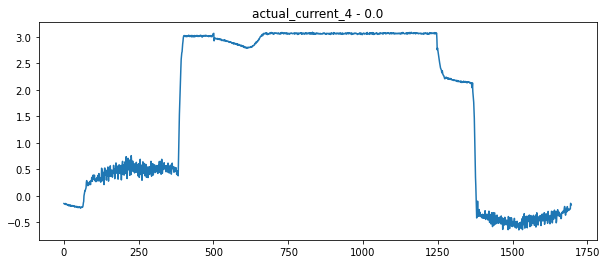

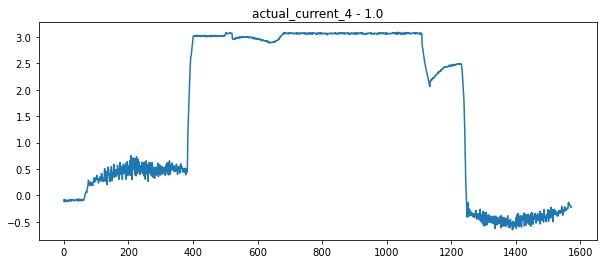

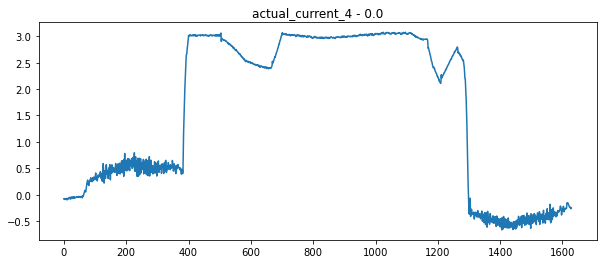

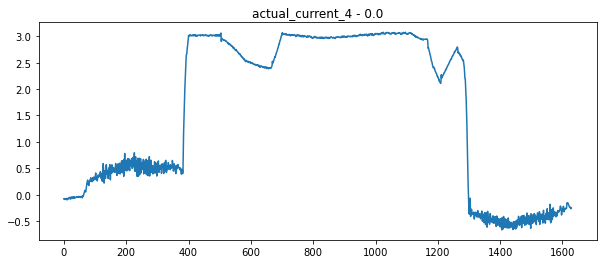

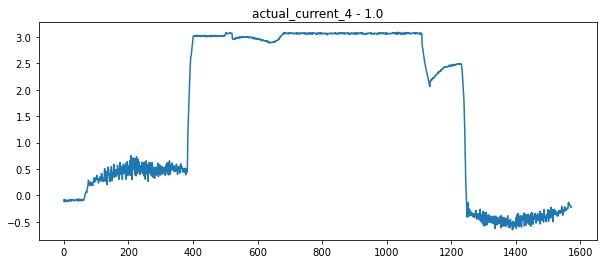

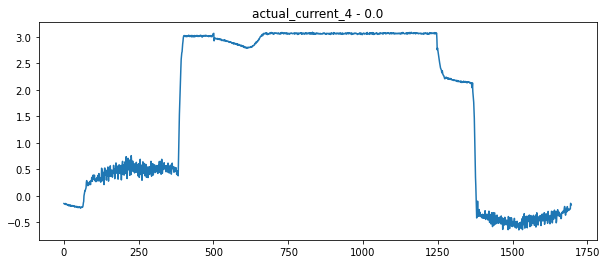

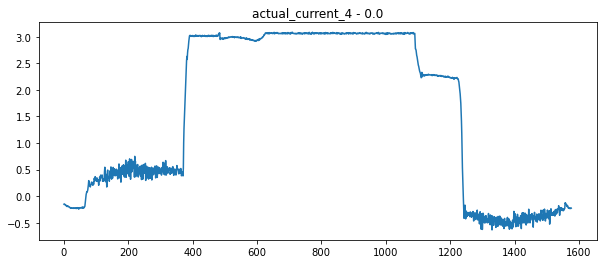

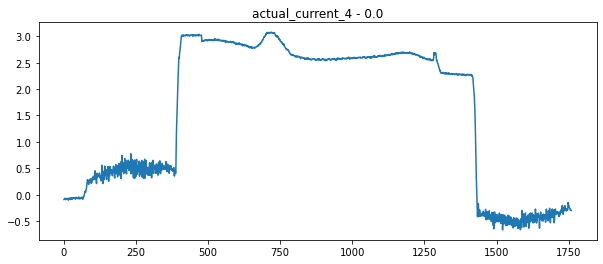

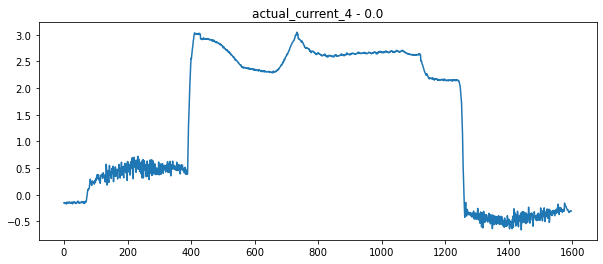

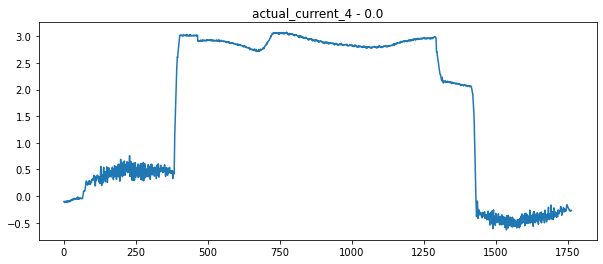

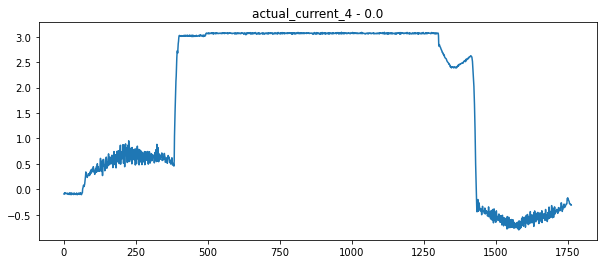

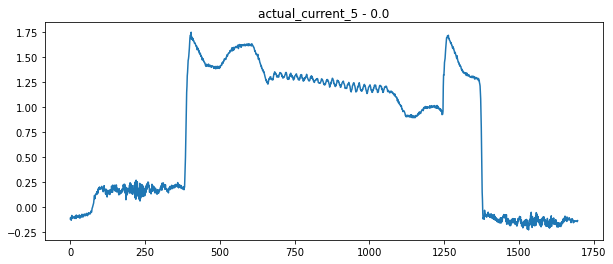

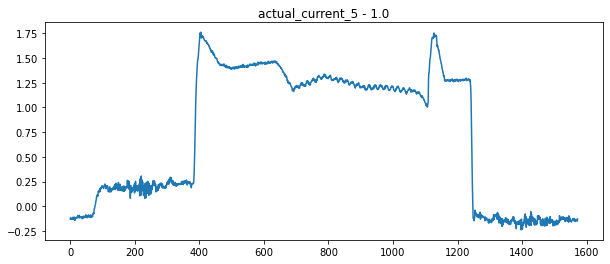

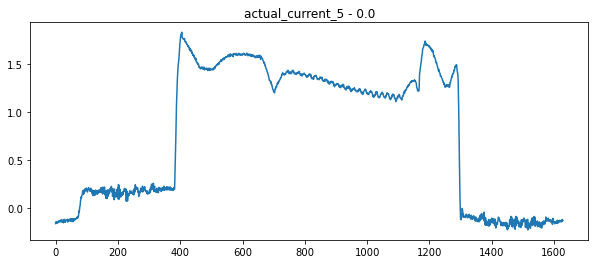

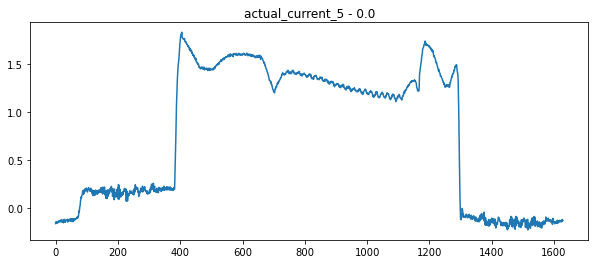

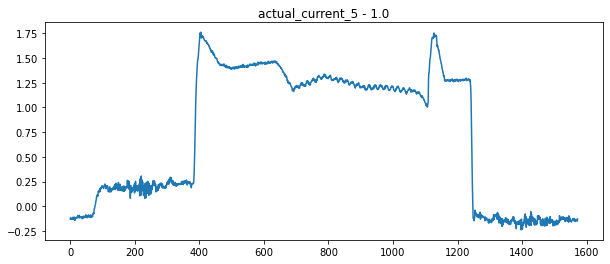

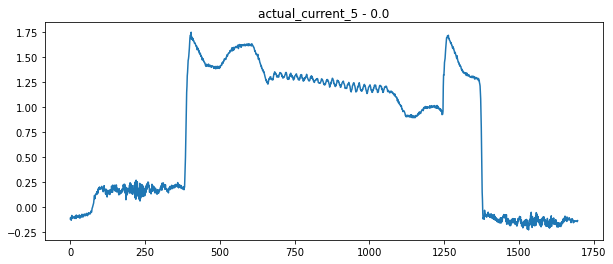

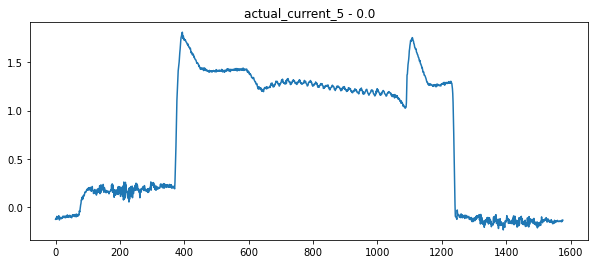

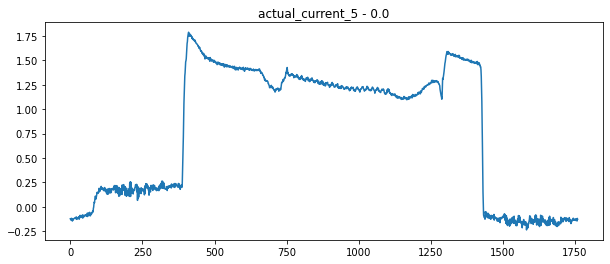

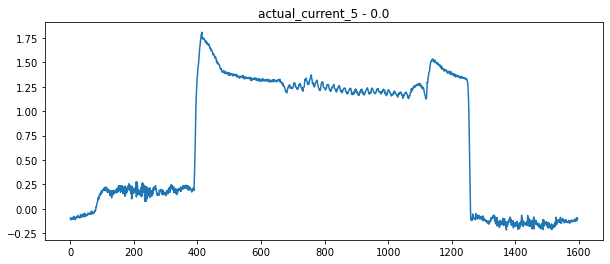

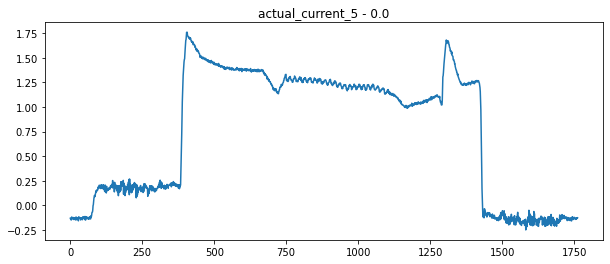

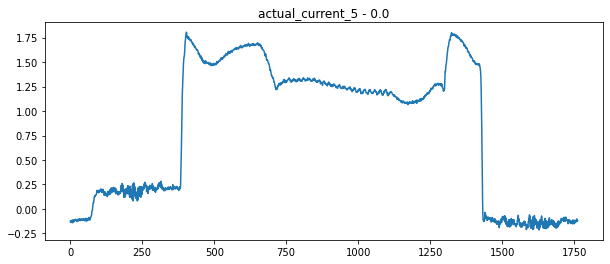

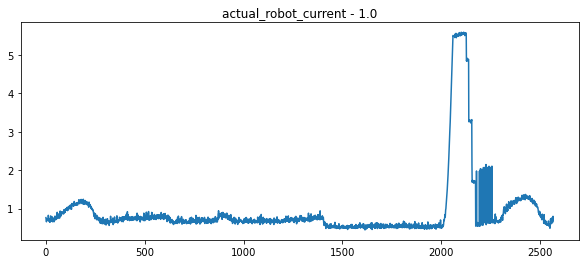

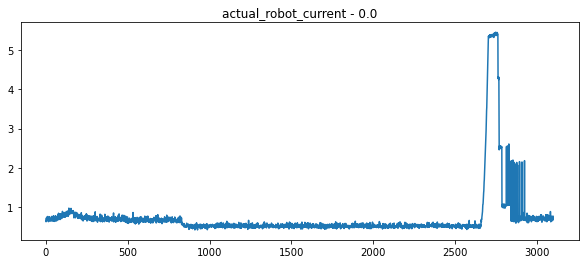

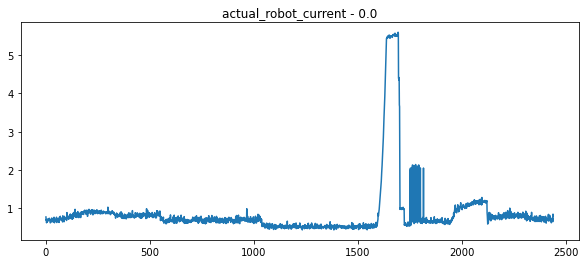

In [13]:
def get_sample_feature(sample, feature):
    sub_df = df.where(df["sample_nr"] == sample).dropna()
    data = sub_df[feature].to_numpy()
    label = sub_df["label"].iloc[0]
    return data, label

for feature, sample_list in critical_samples.items():

    for sample in sample_list:
        fig, ax = plt.subplots(figsize=(10,4))
        data, label = get_sample_feature(sample, feature)
        ax.plot(data)
        ax.set_title(f"{feature} - {label}")

Remove the reviewed outliers:

In [14]:
df.set_index("sample_nr", drop=True, inplace=True)

In [15]:
drop_samples = [int(s) for sl in critical_samples.values() for s in sl]
df.drop(index=drop_samples, inplace=True)

/Users/david/miniforge3/envs/m1tf/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Check time integrity
Find all samples with bad data quality with respect to sequence length or time resolution

Criteria for removal:
1. if more than 0.1ms (i.e. 10 points) between two subsequent rows of the same sample are missing
2. if the average resolution is too small, i.e. if the average time delta exceeds 10% of the expected time delta
3. if the sequence is very short, i.e. it consist of less than 500 points

In [16]:
# define criteria, according to which samples are excluded
max_time_delta = 0.1
max_mean_time_delta = 0.011
min_length = 500

excluded_samples = pd.DataFrame(columns = ["sample_nr", "label", "exclude_criterion"])

time_df = df[["timestamp", "label"]]

for sample, sub_df in time_df.groupby(["sample_nr"]):
    label = sub_df["label"].iloc[0]
    time = sub_df["timestamp"].to_numpy()
    time_delta = np.diff(time)
    
    # first criterion: check if there are missing data points, i.e. check 
    # whether the time delta between two rows exceeds max_time_delta 
    missing_data_points = np.any(time_delta > max_time_delta)
    
    if missing_data_points:
        excluded_sample = pd.Series({"sample_nr": sample, "label": label, "exclude_criterion": 1})
        excluded_samples = excluded_samples.append(excluded_sample, ignore_index = True)
    
    # second criterion: check if the average resolution of the entire sample
    # is not high enough, i.e. if the sample's mean time_delta exceeds 
    # max_mean_time_delta 
    resolution =  np.mean(time_delta)
    insufficient_resolution = resolution > max_mean_time_delta
    
    if insufficient_resolution:
        excluded_sample = pd.Series({"sample_nr": sample, "label": label, "exclude_criterion": 2}, name = sample)
        excluded_samples = excluded_samples.append(excluded_sample, ignore_index = True)
        
    # third criterion: check if the sub_df (which corresponds to one sample) consists
    # of less than the minimum required length
    
    if len(sub_df) < min_length:
        excluded_sample = pd.Series({"sample_nr": sample, "label": label, "exclude_criterion": 3}, name = sample)
        excluded_samples = excluded_samples.append(excluded_sample, ignore_index = True)
    

excluded_samples.set_index("sample_nr", inplace=True)
num_excluded_samples = len(excluded_samples.index.unique())
print(f'Number of samples, which match any exclude criterion: {num_excluded_samples}')

Number of samples, which match any exclude criterion: 5


In [17]:
excluded_samples

,label,exclude_criterion
sample_nr,,
1195,1,1
1195,1,2
1374,0,1
1374,0,2
2174,0,1
3000,3,1
3190,3,1


In case both screwing and unscrewing samples are considered, for every excluded screwing/unscrewing sample we also need to remove its corresponding unscrewing/screwing example: corresponds to exclude_criterion 9

In [18]:
# finally, drop the excluded samples
df.drop(index = excluded_samples.index.unique(), inplace = True, errors = None)

/Users/david/miniforge3/envs/m1tf/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Drop the unselected columns
This step is done after the quality check, because dataframes with different profiles should contain the same data

In [19]:
# drop the unselected columns (and keep the timestamp)
keep_columns = list(selection["columns"])
keep_columns.extend(list(basic))
df = df[keep_columns]

### Shrink the dataframe
Once data cleaning is finished, some more columns can be removed in order to shrink the dataframe:
* timestamp

Moreover, the label column can be compressed

In [20]:
# Remove the timestamp column
df.drop(columns="timestamp", inplace=True)

# Compress the label column by making it categorical
df["label"] = df["label"].astype("int8")

for col in selection["columns"]:
    if df[col].dtype != bool:
        df[col] = df[col].astype("float32")

# rename the output_double_register_25 column
if "output_double_register_25" in df.columns:
    df.rename(columns={"output_double_register_25": "screwdriver_torque"}, inplace=True)

/Users/david/miniforge3/envs/m1tf/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/ht/74j_l0hj2lzg0r9j2xgjmd3r0000gn/T/ipykernel_38757/2147370871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["label"].astype("int8")
/var/folders/ht/74j_l0hj2lzg0r9j2xgjmd3r0000gn/T/ipykernel_38757/2147370871.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [21]:
df

,screwdriver_torque,label,output_bit_register_66,output_bit_register_64,output_bit_register_65,output_bit_register_67
sample_nr,,,,,,
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
...,...,...,...,...,...,...
4094,0.016,0,False,False,False,False
4094,0.016,0,False,False,False,False
4094,0.016,0,False,False,False,False


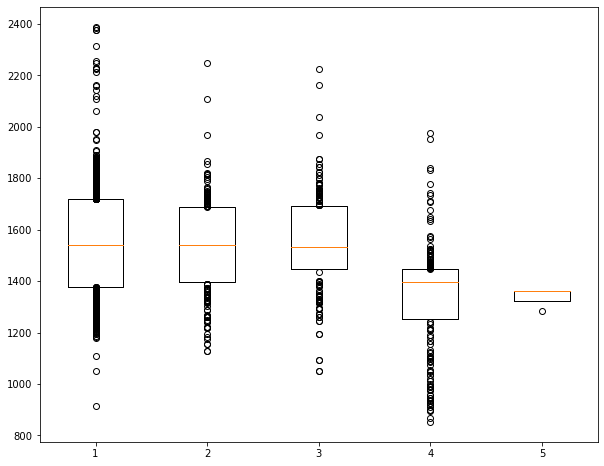

In [22]:
# summarize the cleaned dataframe
sequence_lengths = df.groupby(["sample_nr", "label"])["label"].size().to_frame(name = "sample_length").reset_index()

sample_lengths_per_class = list()
for label, samples in sequence_lengths.groupby(["label"]):
    sample_lengths_per_class.append(samples["sample_length"].to_numpy())
    
fig = plt.figure(figsize=(10,8))
plt.boxplot(sample_lengths_per_class, whis=0)
plt.show()
    

In [23]:
sequence_lengths.where(sequence_lengths["sample_length"] > 1800).dropna()

,sample_nr,label,sample_length
19,40.0,0.0,1866.0
33,68.0,0.0,2121.0
38,78.0,0.0,1821.0
46,94.0,0.0,2230.0
47,96.0,0.0,1827.0
...,...,...,...
1951,3946.0,1.0,1806.0
1971,3986.0,0.0,1808.0
1980,4004.0,0.0,2160.0
1981,4006.0,0.0,1833.0


### Save the cleaned dataset

In [24]:
# Save dataframe
df_filename = "df_torque.h5"
output_path = os.path.join(data_path, df_filename)
df.to_hdf(output_path, key="df", mode="w", format="table")

In [25]:
df

,screwdriver_torque,label,output_bit_register_66,output_bit_register_64,output_bit_register_65,output_bit_register_67
sample_nr,,,,,,
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
2,0.061,0,False,False,False,False
...,...,...,...,...,...,...
4094,0.016,0,False,False,False,False
4094,0.016,0,False,False,False,False
4094,0.016,0,False,False,False,False
